In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading birds data**

In [ ]:
import zipfile
import os
import numpy as np
import shutil
import tensorflow as tf
import math

In [ ]:
#extracting birds data to colab
bird_zip_path='/content/drive/MyDrive/DeepLearningTask2/bird_CUB_200_2011.zip'
extract_path = "/content/task2"
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(bird_zip_path, 'r') as zip_obj:
  zip_obj.extractall(extract_path)

In [ ]:
#Create train and test folder
train_path = "/content/task2/train"
test_path='/content/task2/test'
if not os.path.exists(train_path):
    os.makedirs(train_path)
if not os.path.exists(test_path):
    os.makedirs(test_path)


In [ ]:

img_dir = '/content/task2/CUB_200_2011/images'
img_txt = '/content/task2/CUB_200_2011/images.txt'
split_file = '/content/task2/CUB_200_2011/train_test_split.txt'

test_count = 0
train_count = 0

with open(img_txt, 'r') as img_info:
  with open(split_file, 'r') as split_info:
    for line_img, line_split in zip(img_info, split_info):
      line_img = line_img.strip().split(' ')

      line_split = line_split.strip().split(' ')

      sub_dir=line_img[1].split('/')

      if line_img[0] == line_split[0]:
        if line_split[1] == '0':

          subfolder_path=os.path.join('/content/task2/test',sub_dir[0])
          if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

          path = os.path.join(img_dir, line_img[1])
          #image = tf.keras.utils.load_img(path)
          dest_path = os.path.join(subfolder_path, os.path.basename(path))
          shutil.move(path, dest_path)
          test_count += 1
        elif line_split[1] == '1':
          subfolder_path=os.path.join('/content/task2/train',sub_dir[0])
          if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

          path = os.path.join(img_dir, line_img[1])
          #image = tf.keras.utils.load_img(path)
          dest_path = os.path.join(subfolder_path, os.path.basename(path))
          shutil.move(path, dest_path)
          train_count += 1

print(f"Moved {test_count} images to test directory")
print(f"Moved {train_count} images to train directory")


Moved 5794 images to test directory
Moved 5994 images to train directory


**Loading data using flow_from_directory**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory='/content/task2/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory='/content/task2/train',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    directory='/content/task2/test',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)


Found 5400 images belonging to 200 classes.
Found 594 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher', '042.Ver

**Applying Transfer learning model: Xception**

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freezing base_model
base_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = Dense(200, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/30
168/168 [==============================] - 97s 513ms/step - loss: 4.0736 - accuracy: 0.1380 - val_loss: 2.8485 - val_accuracy: 0.3108
Epoch 2/30
168/168 [==============================] - 85s 508ms/step - loss: 2.6004 - accuracy: 0.3381 - val_loss: 2.4195 - val_accuracy: 0.3785
Epoch 3/30
168/168 [==============================] - 85s 506ms/step - loss: 2.1433 - accuracy: 0.4344 - val_loss: 2.2218 - val_accuracy: 0.4201
Epoch 4/30
168/168 [==============================] - 85s 506ms/step - loss: 1.8648 - accuracy: 0.4892 - val_loss: 2.1189 - val_accuracy: 0.4392
Epoch 5/30
168/168 [==============================] - 85s 508ms/step - loss: 1.7061 - accuracy: 0.5313 - val_loss: 2.0848 - val_accuracy: 0.4566
Epoch 6/30
168/168 [==============================] - 85s 506ms/step - loss: 1.5620 - accuracy: 0.5632 - val_loss: 2.0161 - val_accuracy: 0.4740
Epoch 7/30
168/168 [==============================] - 85s 507ms/step - loss: 1.4680 - accuracy: 0.5788 - val_loss: 2.1096 - val_ac

In [ ]:
results = model.evaluate(test_generator, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[2.152953863143921, 0.5191577672958374]
Test Accuracy: 51.92%


Fine-tuning of the entire model

In [ ]:
# Unfreeze last 15 base model
for layer in base_model.layers[:-15]:
    layer.trainable = True

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
#drop epoch by 1/10 after every 5th epoch
def lr_step_decay(epoch, lr):
    drop_rate = 0.1
    epochs_drop = 5.0
    initial_learning_rate=0.001
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))



lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay)

In [ ]:
'''checkpoint_filepath = "./model_checkpoints/bird_classification_checkpoints.{epoch:03d}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath)'''
from tensorflow.keras.callbacks import ModelCheckpoint
#saving checkpoints only when validation loss decreases
filepath = "./model_checkpoints/bird_classification_checkpoints_finetuned-{epoch:02d}-{val_loss:.2f}.h5"
model_checkpoint_callback = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=[lr_callback,model_checkpoint_callback]
          )

Epoch 1/20
168/168 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.6598
Epoch 1: val_loss improved from inf to 2.06677, saving model to ./model_checkpoints/bird_classification_checkpoints_finetuned-01-2.07.h5
168/168 [==============================] - 110s 515ms/step - loss: 1.2014 - accuracy: 0.6598 - val_loss: 2.0668 - val_accuracy: 0.5208 - lr: 0.0010
Epoch 2/20
168/168 [==============================] - ETA: 0s - loss: 0.8142 - accuracy: 0.7554
Epoch 2: val_loss improved from 2.06677 to 1.96152, saving model to ./model_checkpoints/bird_classification_checkpoints_finetuned-02-1.96.h5
168/168 [==============================] - 86s 511ms/step - loss: 0.8142 - accuracy: 0.7554 - val_loss: 1.9615 - val_accuracy: 0.5087 - lr: 0.0010
Epoch 3/20
168/168 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.7789
Epoch 3: val_loss did not improve from 1.96152
168/168 [==============================] - 84s 502ms/step - loss: 0.7217 - accuracy: 0.7789 

In [ ]:
results = model.evaluate(test_generator, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[1.6083483695983887, 0.7178115248680115]
Test Accuracy: 71.78%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Saving checkpoints to drive
shutil.copytree('/content/model_checkpoints','/content/drive/MyDrive/bird_checkpoint_weights')

'/content/drive/MyDrive/bird_checkpoint_weights'

In [ ]:
#Saving model to drive
model.save('/content/drive/MyDrive/bird_classification')

**Loading model from drive**

In [ ]:
#loading model
from tensorflow.keras.models import load_model
model_loaded = load_model('/content/drive/MyDrive/bird_classification')

Run the block "Loading birds data", change the bird_zip_file accordingly

Run the block "Loading data using flow_from_directory"

In [ ]:
import os
import tensorflow as tf
import zipfile
#CHANGE test_imgs path here, it should be a zip file
test_imgs='/content/drive/MyDrive/birdtest.zip'
extract_path = "/content/task2/test_imgs/test"
test_img='/content/task2/test_imgs/test'

if not os.path.exists(extract_path):
    os.makedirs(extract_path)

with zipfile.ZipFile(test_imgs, 'r') as zip_obj:
  zip_obj.extractall(extract_path)


In [ ]:
for images in os.listdir(test_img):
  if (images.endswith(".jpg")):
    img_path=test_img+'/'+images
    img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_loaded.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(f"Image label: {images}")

    print(
    "Predicted class: {}."
    .format(class_names[np.argmax(score)]))



1/1 [==============================] - 0s 28ms/step
Image label: Task2_bird_2.jpg
Predicted class: 054.Blue_Grosbeak.
1/1 [==============================] - 0s 26ms/step
Image label: Task2_bird_1.jpg
Predicted class: 054.Blue_Grosbeak.
1/1 [==============================] - 0s 26ms/step
Image label: Task2_bird_3.jpg
Predicted class: 054.Blue_Grosbeak.
1/1 [==============================] - 0s 26ms/step
Image label: Task2_bird_4.jpg
Predicted class: 054.Blue_Grosbeak.


In [ ]:
results = model_loaded.evaluate(test_generator, verbose=0)
print(results)
print(f"Test Accuracy: {np.round(results[1] * 100,2)}%")

[1.608345866203308, 0.7176389098167419]
Test Accuracy: 71.76%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model_loaded.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)


182/182 [==============================] - 30s 162ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

# finding the test accuracy
accuracy = accuracy_score(test_generator.classes,y_pred)
# calculating the precision
precision_score_val = precision_score(test_generator.classes,y_pred,average='weighted')
# calculating the recall_score
recall_score_val = recall_score(test_generator.classes,y_pred,average='weighted')

confusion_mat = confusion_matrix(test_generator.classes, y_pred)


In [ ]:
print(f'''Model Results:\n
      Accuracy: {round(accuracy,3)}\n
      Precision Score: {round(precision_score_val,3)}\n
      Recall Score: {round(recall_score_val,3)}\n''')


Model Results:
 
      Accuracy: 0.718
 
      Precision Score: 0.731
 
      Recall Score: 0.718



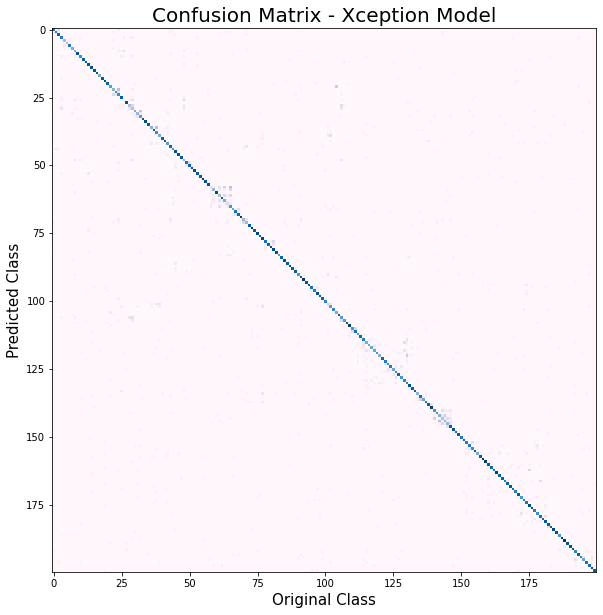

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.imshow(confusion_mat, cmap='PuBu', interpolation='nearest')
plt.title("Confusion Matrix - Xception Model", fontsize = 20)
plt.xlabel("Original Class", fontsize = 15)
plt.ylabel("Predicted Class", fontsize = 15)
plt.show()

In [ ]:
'''model.save("/content/drive/MyDrive/bird_classification_model")'''

In [ ]:
'''#loading model
from tensorflow.keras import models
model = models.load_model("/content/drive/MyDrive/bird_classification_model")'''